<a href="https://colab.research.google.com/github/kornellewy/numpy-pandas-sklearn-scipy-exercise/blob/master/sklearn_cw_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import sklearn
import numpy as np
import pandas as pd

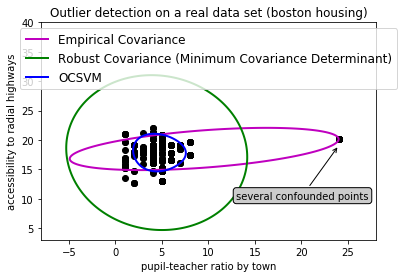

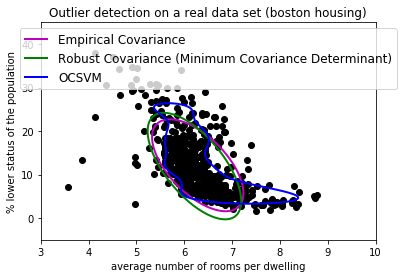

In [0]:
# 1 Outlier detection on a real data set
import numpy as np
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM
import matplotlib.pyplot as plt
import matplotlib.font_manager
from sklearn.datasets import load_boston

X1 = load_boston()['data'][:, [8, 10]] # 2 clasters
X2 = load_boston()['data'][:, [5, 12]] # bananna shape

# Define "classifiers" to be used
classifiers = {"Empirical Covariance": EllipticEnvelope(support_fraction=1.,
                                                        contamination=0.261),
               "Robust Covariance (Minimum Covariance Determinant)":
               EllipticEnvelope(contamination=0.261),
               "OCSVM": OneClassSVM(nu=0.261, gamma=0.05)}

colors = ['m', 'g', 'b']
legend1 = {}
legend2 = {}

# Learn a frontier for outlier detection with several classifiers
xx1, yy1 = np.meshgrid(np.linspace(-8, 28, 500), np.linspace(3, 40, 500))
xx2, yy2 = np.meshgrid(np.linspace(3, 10, 500), np.linspace(-5, 45, 500))
for i, (clf_name, clf) in enumerate(classifiers.items()):
    plt.figure(1)
    clf.fit(X1)
    Z1 = clf.decision_function(np.c_[xx1.ravel(), yy1.ravel()])
    Z1 = Z1.reshape(xx1.shape)
    legend1[clf_name] = plt.contour(
        xx1, yy1, Z1, levels=[0], linewidths=2, colors=colors[i])
    plt.figure(2)
    clf.fit(X2)
    Z2 = clf.decision_function(np.c_[xx2.ravel(), yy2.ravel()])
    Z2 = Z2.reshape(xx2.shape)
    legend2[clf_name] = plt.contour(
        xx2, yy2, Z2, levels=[0], linewidths=2, colors=colors[i])

legend1_values_list = list(legend1.values())
legend1_keys_list = list(legend1.keys())

# Plot the results (= shape of the data points cloud)
plt.figure(1)  # two clusters
plt.title("Outlier detection on a real data set (boston housing)")
plt.scatter(X1[:, 0], X1[:, 1], color='black')
bbox_args = dict(boxstyle="round", fc="0.8")
arrow_args = dict(arrowstyle="->")
plt.annotate("several confounded points", xy=(24, 19),
             xycoords="data", textcoords="data",
             xytext=(13, 10), bbox=bbox_args, arrowprops=arrow_args)
plt.xlim((xx1.min(), xx1.max()))
plt.ylim((yy1.min(), yy1.max()))
plt.legend((legend1_values_list[0].collections[0],
            legend1_values_list[1].collections[0],
            legend1_values_list[2].collections[0]),
           (legend1_keys_list[0], legend1_keys_list[1], legend1_keys_list[2]),
           loc="upper center",
           prop=matplotlib.font_manager.FontProperties(size=12))
plt.ylabel("accessibility to radial highways")
plt.xlabel("pupil-teacher ratio by town")

legend2_values_list = list(legend2.values())
legend2_keys_list = list(legend2.keys())

plt.figure(2)  # "banana" shape
plt.title("Outlier detection on a real data set (boston housing)")
plt.scatter(X2[:, 0], X2[:, 1], color='black')
plt.xlim((xx2.min(), xx2.max()))
plt.ylim((yy2.min(), yy2.max()))
plt.legend((legend2_values_list[0].collections[0],
            legend2_values_list[1].collections[0],
            legend2_values_list[2].collections[0]),
           (legend2_keys_list[0], legend2_keys_list[1], legend2_keys_list[2]),
           loc="upper center",
           prop=matplotlib.font_manager.FontProperties(size=12))
plt.ylabel("% lower status of the population")
plt.xlabel("average number of rooms per dwelling")

plt.show()

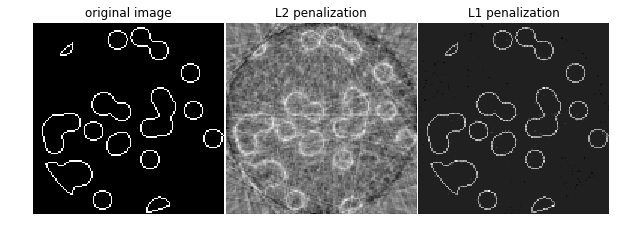

In [0]:
# 2 Compressive sensing: tomography reconstruction with L1 prior (Lasso)
import numpy as np
from scipy import sparse
from scipy import ndimage
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt


def _weights(x, dx=1, orig=0):
    x = np.ravel(x)
    floor_x = np.floor((x - orig) / dx).astype(np.int64)
    alpha = (x - orig - floor_x * dx) / dx
    return np.hstack((floor_x, floor_x + 1)), np.hstack((1 - alpha, alpha))

def _generate_center_coordinates(l_x):
    X, Y = np.mgrid[:l_x, :l_x].astype(np.float64)
    center = l_x / 2.
    X += 0.5 - center
    Y += 0.5 - center
    return X, Y

def build_projection_operator(l_x, n_dir):
    """ Compute the tomography design matrix.

    Parameters
    ----------

    l_x : int
        linear size of image array

    n_dir : int
        number of angles at which projections are acquired.

    Returns
    -------
    p : sparse matrix of shape (n_dir l_x, l_x**2)
    """
    X, Y = _generate_center_coordinates(l_x)
    angles = np.linspace(0, np.pi, n_dir, endpoint=False)
    data_inds, weights, camera_inds = [], [], []
    data_unravel_indices = np.arange(l_x ** 2)
    data_unravel_indices = np.hstack((data_unravel_indices,
                                      data_unravel_indices))
    for i, angle in enumerate(angles):
        Xrot = np.cos(angle) * X - np.sin(angle) * Y
        inds, w = _weights(Xrot, dx=1, orig=X.min())
        mask = np.logical_and(inds >= 0, inds < l_x)
        weights += list(w[mask])
        camera_inds += list(inds[mask] + i * l_x)
        data_inds += list(data_unravel_indices[mask])
    proj_operator = sparse.coo_matrix((weights, (camera_inds, data_inds)))
    return proj_operator

def generate_synthetic_data():
    """ Synthetic binary data """
    rs = np.random.RandomState(0)
    n_pts = 36
    x, y = np.ogrid[0:l, 0:l]
    mask_outer = (x - l / 2.) ** 2 + (y - l / 2.) ** 2 < (l / 2.) ** 2
    mask = np.zeros((l, l))
    points = l * rs.rand(2, n_pts)
    mask[(points[0]).astype(np.int), (points[1]).astype(np.int)] = 1
    mask = ndimage.gaussian_filter(mask, sigma=l / n_pts)
    res = np.logical_and(mask > mask.mean(), mask_outer)
    return np.logical_xor(res, ndimage.binary_erosion(res))

# Generate synthetic images, and projections
l = 128
proj_operator = build_projection_operator(l, l // 7)
data = generate_synthetic_data()
proj = proj_operator * data.ravel()[:, np.newaxis]
proj += 0.15 * np.random.randn(*proj.shape)

# Reconstruction with L2 (Ridge) penalization
rgr_ridge = Ridge(alpha=0.2)
rgr_ridge.fit(proj_operator, proj.ravel())
rec_l2 = rgr_ridge.coef_.reshape(l, l)

# Reconstruction with L1 (Lasso) penalization
# the best value of alpha was determined using cross validation
# with LassoCV
rgr_lasso = Lasso(alpha=0.001)
rgr_lasso.fit(proj_operator, proj.ravel())
rec_l1 = rgr_lasso.coef_.reshape(l, l)

plt.figure(figsize=(8, 3.3))
plt.subplot(131)
plt.imshow(data, cmap=plt.cm.gray, interpolation='nearest')
plt.axis('off')
plt.title('original image')
plt.subplot(132)
plt.imshow(rec_l2, cmap=plt.cm.gray, interpolation='nearest')
plt.title('L2 penalization')
plt.axis('off')
plt.subplot(133)
plt.imshow(rec_l1, cmap=plt.cm.gray, interpolation='nearest')
plt.title('L1 penalization')
plt.axis('off')

plt.subplots_adjust(hspace=0.01, wspace=0.01, top=1, bottom=0, left=0,
                    right=1)

plt.show()

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7
Extracting the top 150 eigenfaces from 966 faces
done in 0.228s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.024s
Fitting the classifier to the training set
done in 46.013s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.005, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Predicting people's names on the test set
done in 0.076s
                   precision    recall  f1-score   support

     Ariel Sharon       0.78      0.54      0.64        13
     Colin Powell       0.80      0.87      0.83        60
  Donald Rumsfeld       0.90      0.67      0.77        27
    George W Bush       0.84      0.98      0.90       146
Gerhard Schroeder       0.95      0.76      0.84        25
      Hugo Chavez       1.00      0.60      0.

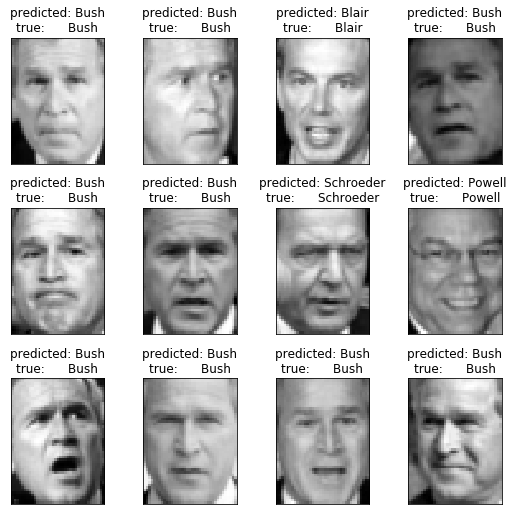

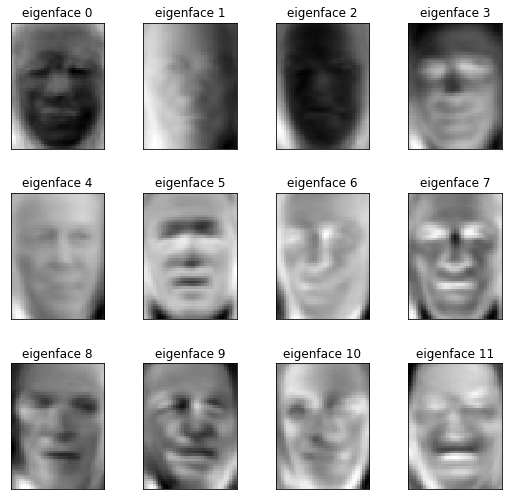

In [0]:
# 3 Faces recognition example using eigenfaces and SVMs
from time import time
import logging
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape
# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]
# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]
print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)
# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150
print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))
eigenfaces = pca.components_.reshape((n_components, h, w))
print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))
# Train a SVM classification model
print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                   param_grid, cv=5, iid=False)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)
# Quantitative evaluation of the model quality on the test set
print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))
print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))
# Quantitative evaluation of the model quality on the test set
print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))
print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))
# #############################################################################
# Qualitative evaluation of the predictions using matplotlib
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
# plot the result of the prediction on a portion of the test set
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]
plot_gallery(X_test, prediction_titles, h, w)
# plot the gallery of the most significative eigenfaces
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)
plt.show()

2019-08-05 15:42:44,997 Downloading 20news dataset. This may take a few minutes.
2019-08-05 15:42:45,000 Downloading dataset from https://ndownloader.figshare.com/files/5975967 (14 MB)


Benchmarking SGDClassifier(alpha=0.001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.25, learning_rate='optimal', loss='modified_huber',
              max_iter=1000, n_iter_no_change=5, n_jobs=None,
              penalty='elasticnet', power_t=0.5, random_state=None,
              shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
              warm_start=False)
Complexity: 4466 | Hamming Loss (Misclassification Ratio): 0.2491 | Pred. Time: 0.029793s

Benchmarking SGDClassifier(alpha=0.001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.5, learning_rate='optimal', loss='modified_huber',
              max_iter=1000, n_iter_no_change=5, n_jobs=None,
              penalty='elasticnet', power_t=0.5, random_state=None,
              shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
        

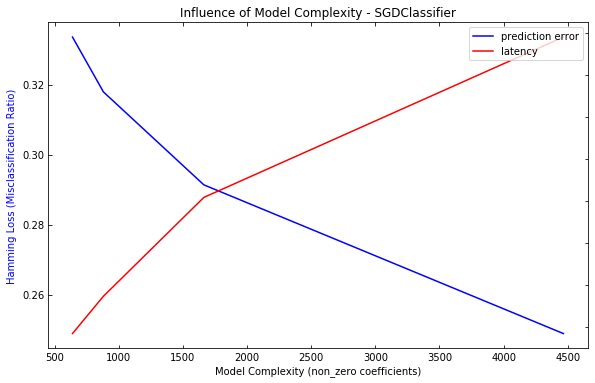

Benchmarking NuSVR(C=1000.0, cache_size=200, coef0=0.0, degree=3, gamma=3.0517578125e-05,
      kernel='rbf', max_iter=-1, nu=0.1, shrinking=True, tol=0.001,
      verbose=False)
Complexity: 69 | MSE: 31.8139 | Pred. Time: 0.000333s

Benchmarking NuSVR(C=1000.0, cache_size=200, coef0=0.0, degree=3, gamma=3.0517578125e-05,
      kernel='rbf', max_iter=-1, nu=0.25, shrinking=True, tol=0.001,
      verbose=False)
Complexity: 136 | MSE: 25.6140 | Pred. Time: 0.000632s

Benchmarking NuSVR(C=1000.0, cache_size=200, coef0=0.0, degree=3, gamma=3.0517578125e-05,
      kernel='rbf', max_iter=-1, nu=0.5, shrinking=True, tol=0.001,
      verbose=False)
Complexity: 244 | MSE: 22.3375 | Pred. Time: 0.001029s

Benchmarking NuSVR(C=1000.0, cache_size=200, coef0=0.0, degree=3, gamma=3.0517578125e-05,
      kernel='rbf', max_iter=-1, nu=0.75, shrinking=True, tol=0.001,
      verbose=False)
Complexity: 351 | MSE: 21.3688 | Pred. Time: 0.001443s

Benchmarking NuSVR(C=1000.0, cache_size=200, coef0=0.0, deg

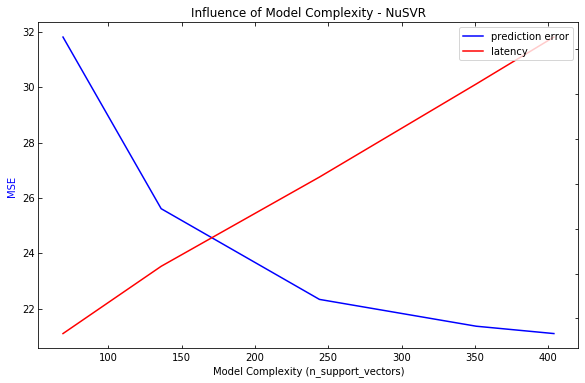

Benchmarking GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=10,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
Complexity: 10 | MSE: 29.0148 | Pred. Time: 0.000183s

Benchmarking GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_

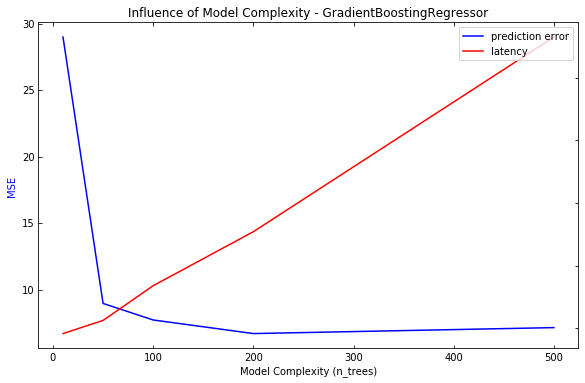

In [0]:
# 4 Model Complexity Influence
import time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.parasite_axes import host_subplot
from mpl_toolkits.axisartist.axislines import Axes
from scipy.sparse.csr import csr_matrix
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.svm.classes import NuSVR
from sklearn.ensemble.gradient_boosting import GradientBoostingRegressor
from sklearn.linear_model.stochastic_gradient import SGDClassifier
from sklearn.metrics import hamming_loss

np.random.seed(0)


def generate_data(case, sparse=False):
    """Generate regression/classification data."""
    bunch = None
    if case == 'regression':
        bunch = datasets.load_boston()
    elif case == 'classification':
        bunch = datasets.fetch_20newsgroups_vectorized(subset='all')
    X, y = shuffle(bunch.data, bunch.target)
    offset = int(X.shape[0] * 0.8)
    X_train, y_train = X[:offset], y[:offset]
    X_test, y_test = X[offset:], y[offset:]
    if sparse:
        X_train = csr_matrix(X_train)
        X_test = csr_matrix(X_test)
    else:
        X_train = np.array(X_train)
        X_test = np.array(X_test)
    y_test = np.array(y_test)
    y_train = np.array(y_train)
    data = {'X_train': X_train, 'X_test': X_test, 'y_train': y_train,
            'y_test': y_test}
    return data


def benchmark_influence(conf):
    """
    Benchmark influence of :changing_param: on both MSE and latency.
    """
    prediction_times = []
    prediction_powers = []
    complexities = []
    for param_value in conf['changing_param_values']:
        conf['tuned_params'][conf['changing_param']] = param_value
        estimator = conf['estimator'](**conf['tuned_params'])
        print("Benchmarking %s" % estimator)
        estimator.fit(conf['data']['X_train'], conf['data']['y_train'])
        conf['postfit_hook'](estimator)
        complexity = conf['complexity_computer'](estimator)
        complexities.append(complexity)
        start_time = time.time()
        for _ in range(conf['n_samples']):
            y_pred = estimator.predict(conf['data']['X_test'])
        elapsed_time = (time.time() - start_time) / float(conf['n_samples'])
        prediction_times.append(elapsed_time)
        pred_score = conf['prediction_performance_computer'](
            conf['data']['y_test'], y_pred)
        prediction_powers.append(pred_score)
        print("Complexity: %d | %s: %.4f | Pred. Time: %fs\n" % (
            complexity, conf['prediction_performance_label'], pred_score,
            elapsed_time))
    return prediction_powers, prediction_times, complexities


def plot_influence(conf, mse_values, prediction_times, complexities):
    """
    Plot influence of model complexity on both accuracy and latency.
    """
    plt.figure(figsize=(12, 6))
    host = host_subplot(111, axes_class=Axes)
    plt.subplots_adjust(right=0.75)
    par1 = host.twinx()
    host.set_xlabel('Model Complexity (%s)' % conf['complexity_label'])
    y1_label = conf['prediction_performance_label']
    y2_label = "Time (s)"
    host.set_ylabel(y1_label)
    par1.set_ylabel(y2_label)
    p1, = host.plot(complexities, mse_values, 'b-', label="prediction error")
    p2, = par1.plot(complexities, prediction_times, 'r-',
                    label="latency")
    host.legend(loc='upper right')
    host.axis["left"].label.set_color(p1.get_color())
    par1.axis["right"].label.set_color(p2.get_color())
    plt.title('Influence of Model Complexity - %s' % conf['estimator'].__name__)
    plt.show()


def _count_nonzero_coefficients(estimator):
    a = estimator.coef_.toarray()
    return np.count_nonzero(a)

# #############################################################################
# Main code
regression_data = generate_data('regression')
classification_data = generate_data('classification', sparse=True)
configurations = [
    {'estimator': SGDClassifier,
     'tuned_params': {'penalty': 'elasticnet', 'alpha': 0.001, 'loss':
                      'modified_huber', 'fit_intercept': True, 'tol': 1e-3},
     'changing_param': 'l1_ratio',
     'changing_param_values': [0.25, 0.5, 0.75, 0.9],
     'complexity_label': 'non_zero coefficients',
     'complexity_computer': _count_nonzero_coefficients,
     'prediction_performance_computer': hamming_loss,
     'prediction_performance_label': 'Hamming Loss (Misclassification Ratio)',
     'postfit_hook': lambda x: x.sparsify(),
     'data': classification_data,
     'n_samples': 30},
    {'estimator': NuSVR,
     'tuned_params': {'C': 1e3, 'gamma': 2 ** -15},
     'changing_param': 'nu',
     'changing_param_values': [0.1, 0.25, 0.5, 0.75, 0.9],
     'complexity_label': 'n_support_vectors',
     'complexity_computer': lambda x: len(x.support_vectors_),
     'data': regression_data,
     'postfit_hook': lambda x: x,
     'prediction_performance_computer': mean_squared_error,
     'prediction_performance_label': 'MSE',
     'n_samples': 30},
    {'estimator': GradientBoostingRegressor,
     'tuned_params': {'loss': 'ls'},
     'changing_param': 'n_estimators',
     'changing_param_values': [10, 50, 100, 200, 500],
     'complexity_label': 'n_trees',
     'complexity_computer': lambda x: x.n_estimators,
     'data': regression_data,
     'postfit_hook': lambda x: x,
     'prediction_performance_computer': mean_squared_error,
     'prediction_performance_label': 'MSE',
     'n_samples': 30},
]
for conf in configurations:
    prediction_performances, prediction_times, complexities = \
        benchmark_influence(conf)
    plot_influence(conf, prediction_performances, prediction_times,
                   complexities)